# Задача классификации

1. Байесовская классификация.
2. Деревья решений.

## Импорт библиотек

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#для разбиения данных на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB #вероятностная модель классификатора на основе теоремы Байеса
from sklearn.tree import DecisionTreeClassifier, export_graphviz #модель деревьев решений с визуализацией
from sklearn.ensemble import BaggingClassifier #модель беггинга
from sklearn.ensemble import RandomForestClassifier #библиотека построения классификатора случайного леса
from sklearn.ensemble import GradientBoostingClassifier #библиотека построения классификатора через градиентный бустинг

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #показатели качества модели
from sklearn.metrics import confusion_matrix #для построения матрицы ошибок

#библиотеки для визуализации графиков
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import display

#игнорирование предупреждений
import warnings

## Набор данных

Исходный набор данных: [Gym Members Exercise Dataset](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset)

Данные хранятся в csv файле. 

Объем данных: 973 записи о физических зарактеристиках и данных о тренировках.

Для решения задачи классификации за целевую переменную выбран признак Пол (Gender). Он принимает одно из двух значений: Male и Female.

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gym-members-exercise-dataset/gym_members_exercise_tracking.csv


In [3]:
df = pd.read_csv('/kaggle/input/gym-members-exercise-dataset/gym_members_exercise_tracking.csv') 
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

Для удобства обучения модели, перекодируем признак Gender в числовой формат:
- 0 = Male
- 1 = Female.
  
Аналогичным образом перекодируем признак Workout_Type.

In [5]:
# признак Gender
df['NumGender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# признак Workout_Type
workout_type_mapping = {value: idx for idx, value in enumerate(df['Workout_Type'].unique())}
print("Словарь для перекодирования Workout_Type:", workout_type_mapping)
df['Workout_Type_Num'] = df['Workout_Type'].map(workout_type_mapping)

Словарь для перекодирования Workout_Type: {'Yoga': 0, 'HIIT': 1, 'Cardio': 2, 'Strength': 3}


In [6]:
dfCurrent = df.drop(['Gender', 'Workout_Type'], axis=1)

In [7]:
dfCurrent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Weight (kg)                    973 non-null    float64
 2   Height (m)                     973 non-null    float64
 3   Max_BPM                        973 non-null    int64  
 4   Avg_BPM                        973 non-null    int64  
 5   Resting_BPM                    973 non-null    int64  
 6   Session_Duration (hours)       973 non-null    float64
 7   Calories_Burned                973 non-null    float64
 8   Fat_Percentage                 973 non-null    float64
 9   Water_Intake (liters)          973 non-null    float64
 10  Workout_Frequency (days/week)  973 non-null    int64  
 11  Experience_Level               973 non-null    int64  
 12  BMI                            973 non-null    flo

## Байесовская классификация

1. Выполните классификацию набора данных с помощью Байесовской классификации, варьируя соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 5%.
2. Вычислите показатели качества классификации: аккуратность (accuracy), точность (precision), полнота (recall), F-мера. Выполните визуализацию полученных результатов в виде диаграмм.
3. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:
    - формулировка задания;
    - гиперссылка на каталог репозитория с исходными текстами, набором данных и др. сопутствующими материалами;
    - рисунки с результатами визуализации;
    - пояснения, раскрывающие смысл полученных результатов.

###  Классификация и вычисление метрик

Байесовска классификация основана на теореме Байеса:. Она позволяет предсказать вероятность принадлежности объекта к классу. [GaussianNB](https://scikit-learn.ru/stable/modules/naive_bayes.html) из scikit-learn реализует наивный Баейсовский классификатор, предполагая, что признаки являются независимыми, и используя нормальное распределение Гаусса для моделирования вероятностей. 

Обучение модели: рассчитать априорные вероятности каждого класса как отношение количества наблюдений определенного класса к общему числу наблюдений. Далее для предсказания вычисляется вероятность по формуле нормального распределения, после чего происходит расчет апостериорной вероятности. Затем выбирается результат, для которого эта вероятность будет максимальна.

Параметры модели.
1. class_prior_: показывают априорные вероятности для каждого класса (Male и Female) до учета данных, насколько сбалансированы в обучающей выборке классы.
2. class_count_: количество образцов в каждом классе после разбиения данных (сбалансированность разбиения).
3. theta_: средние значения всех признаков для кжадого класса.
4. var_: дисперсия, показывающая степень разброса значений признаков вокруг среднего значения (для каждого класса).
5. epsilon_: добавочное значение дисперсии в случае малых исходных значений.

Метрики модели.
1. Accuracy (точность): доля правильных предсказаний среди общего числа предсказаний.
2. Precision (точность предсказания): доля верно-положтельных предсказаний среди всех положительных (стремится к минимизации количества ложно-положительных предсказаний).
3. Recall (полнота): доля верно-положительных предсказаний среди всех верно-положительных.
4. F1-Score: гармоническое среднее между Precision и Recall.

In [8]:
# Функция для выполнения классификации и вычисления метрик
# входные данные: признаки модели, целевая переменная, доля тестовой выборки
# выходные данные: аккуратность (accuracy), точность (precision), полнота (recall), F-мера обученной модели.

def classify_and_evaluate(X, y, test_size):
    # деление данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # обучение Байесовского классификатора
    model = GaussianNB()
    model.fit(X_train, y_train)

    # параметры модели 
    print("Модель с объемом тестовой выборки:", test_size)
    print("Априорные вероятности классов:", model.class_prior_)
    print("Количество образцов в каждом классе:", model.class_count_)
    print("Средние значения признаков для каждого класса:", model.theta_)
    print("Дисперсии признаков для каждого класса:", model.var_)
    print("Добавка к дисперсии для численной стабильности:", model.epsilon_)
    print("\n\n")

    # предсказание на тестовой
    y_pred = model.predict(X_test)
    
    # метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1

In [9]:
results = {
    'Test_Size': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}
# соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 5%
test_sizes = np.arange(0.4, 0.10, -0.05).tolist()

In [10]:
# Разделение данных на признаки и целевую переменную
X = dfCurrent.drop('NumGender', axis=1)
y = dfCurrent['NumGender']

In [11]:
# Выполнение классификации и оценка метрик для каждого соотношения выборок
for test_size in test_sizes:
    accuracy, precision, recall, f1 = classify_and_evaluate(X, y, test_size)
    results['Test_Size'].append(test_size)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)

Модель с объемом тестовой выборки: 0.4
Априорные вероятности классов: [0.52658662 0.47341338]
Количество образцов в каждом классе: [307. 276.]
Средние значения признаков для каждого класса: [[ 38.81107492  83.59250814   1.79270358 179.21172638 143.7980456
   62.51140065   1.24120521 935.96742671  22.75863192   3.01530945
    3.31270358   1.81107492  26.22892508   1.62214984]
 [ 37.98188406  60.55         1.64637681 180.10869565 143.49637681
   62.20289855   1.27333333 870.11231884  27.84311594   2.21992754
    3.32608696   1.80434783  22.52358696   1.61956522]]
Дисперсии признаков для каждого класса: [[1.43658191e+02 4.79465066e+02 1.27994977e-02 1.46206059e+02
  2.03809450e+02 5.83541775e+01 1.16754540e-01 8.09629306e+04
  3.23363095e+01 2.38177314e-01 8.07826859e-01 5.31155489e-01
  5.42884819e+01 1.30355626e+00]
 [1.51025107e+02 9.65724280e+01 7.91052796e-03 1.27901302e+02
  2.10199335e+02 5.21473109e+01 1.13329936e-01 6.17127954e+04
  3.24775255e+01 1.53987418e-01 8.06783706e-01 5.

In [12]:
results_bayes_df = pd.DataFrame(results)

In [13]:
results_bayes_df.head() 

,Test_Size,Accuracy,Precision,Recall,F1-Score
0,0.40,0.910256,0.875622,0.946237,0.909561
1,0.35,0.914956,0.884615,0.952663,0.917379
2,0.30,0.910959,0.886792,0.946309,0.915584
3,0.25,0.905738,0.880597,0.944000,0.911197
4,0.20,0.902564,0.869159,0.948980,0.907317


Оценка параметров модели.

1. class_prior_: для всех моделей данные хорошо сбалансированы по классам.
2. class_count_: с уменьшением тестовой выборки увеличивается размер обучающей.
3. theta_: средние значения всех признаков для кжадого класса остается примерно постоянным.
4. var_: дисперсия, показывающая степень разброса значений признаков вокруг среднего значения (для каждого класса) остается примерно постоянным.


###  Визуализация результатов

In [14]:
# построение графика с одной метрикой
def metric_visualization(results_df, metrics):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for ax, metric in zip(axes.flat, metrics):
        ax.plot(results_df['Test_Size'], results_df[metric], marker='o')
        ax.set_title(metric)
        ax.set_xlabel('Test Size')
        ax.set_ylabel('Score')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

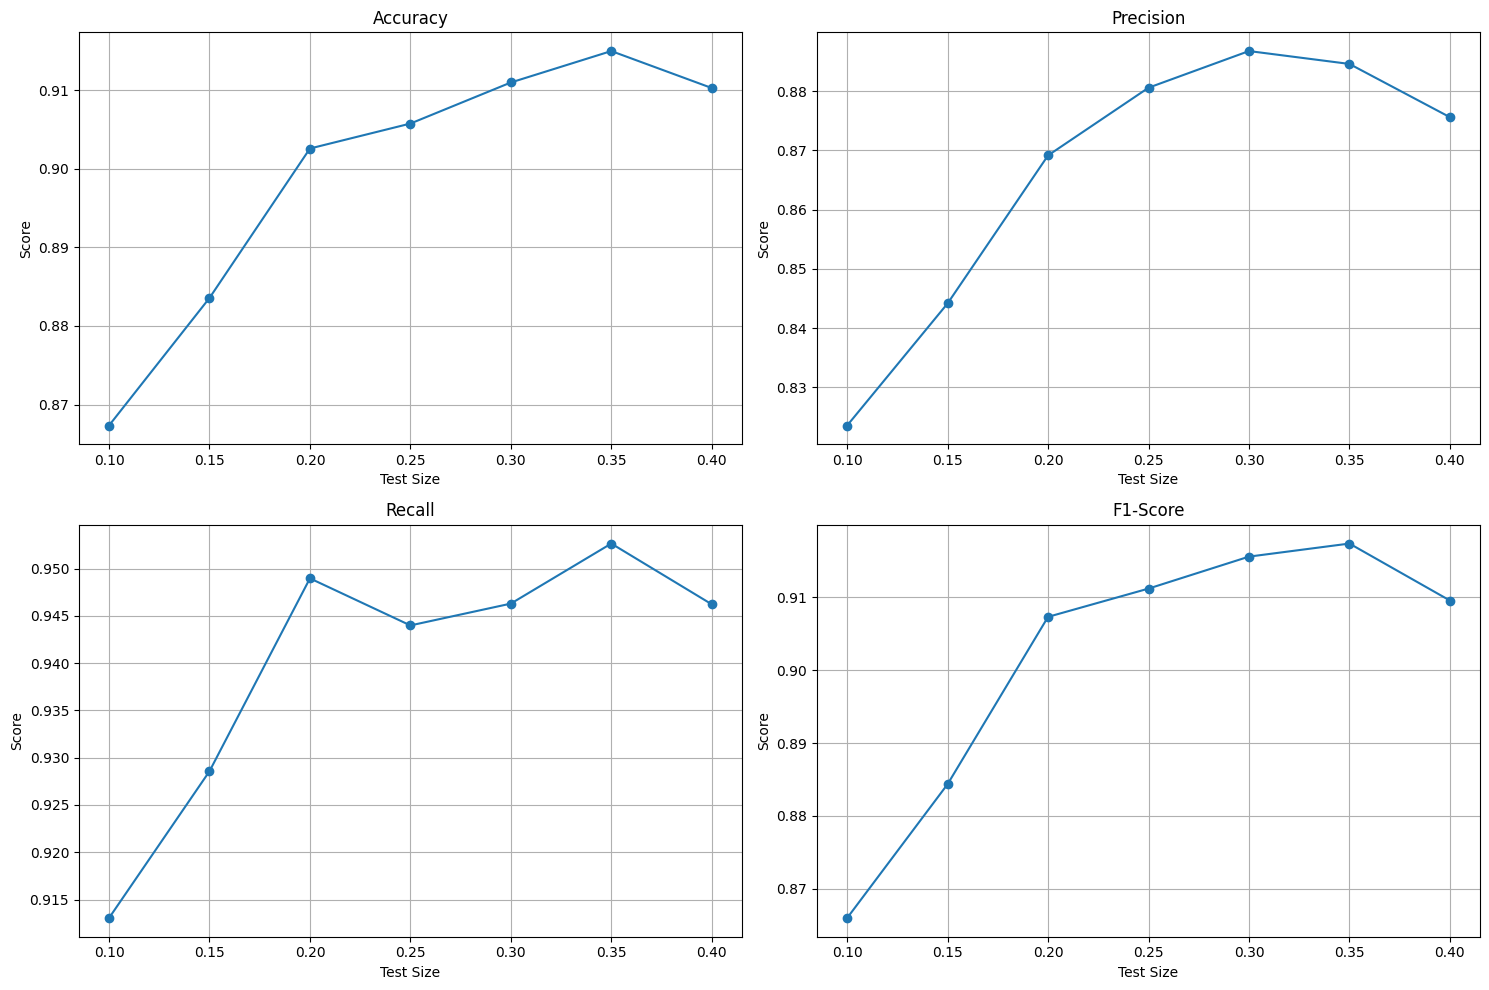

In [15]:
# все метрики
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualization(results_bayes_df, metrics)

In [16]:
def visualization_all_metrics(results_df, title):
    plt.figure(figsize=(10, 5))
    plt.plot(results_df['Test_Size'], results_df['Accuracy'], marker='o', label='Accuracy')
    plt.plot(results_df['Test_Size'], results_df['Precision'], marker='o', label='Precision')
    plt.plot(results_df['Test_Size'], results_df['Recall'], marker='o', label='Recall')
    plt.plot(results_df['Test_Size'], results_df['F1-Score'], marker='o', label='F1-Score')
    plt.title(title)
    plt.xlabel('Test Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

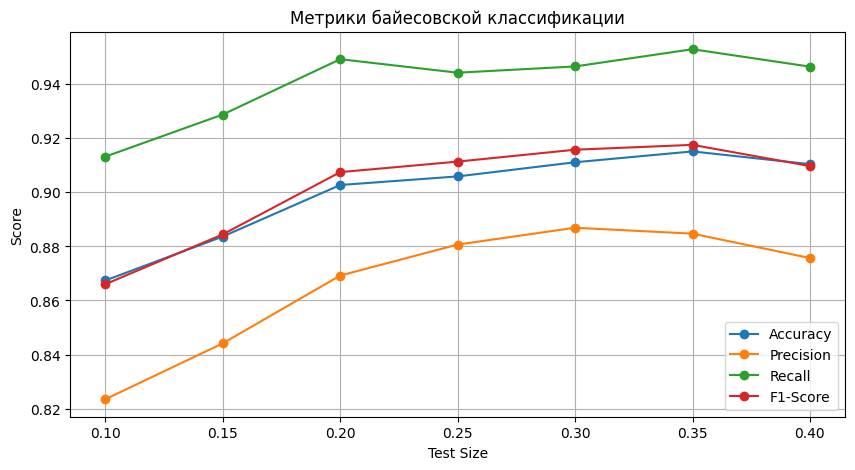

In [17]:
visualization_all_metrics(results_bayes_df, 'Метрики байесовской классификации')

###  Выводы по байесовской классификации
По результатам на графике, можно сделать следующие выводы.
1. Модель лучше обобщает данные, когда на обучение было подано больше данных.
2. С уменьшением тестовой выборки возможно переобучение модели.

## Деревья решений

1. Выполните классификацию набора данных из задания о Байесовской классификации с помощью построения дерева решений, варьируя следующие параметры: критерий выбора атрибута разбиения (information gain, index gini) и соотношение мощностей обучающей и тестовой выборок (от 60%:40% до 90%:10% с шагом 5%).
2. Выполните визуализацию построенных деревьев решений.
Вычислите показатели качества классификации: аккуратность (accuracy), точность (precision), полнота (recall), F-мера.
3. Выполните визуализацию полученных результатов в виде диаграмм.

Алгоритм построения дерева решений: корневой узел проверяет условие на атрибут объекта и создает на основе результатов внутренние узлы. Узлы-листья являются метками класса. Ребрами графа являются переходы исходя из результата выполнения условия. Листы создаются, когда все объекты принадлежат одному классу, иначе выбирается атрибут для разбиения. 

In [18]:
# Функция для выполнения классификации и вычисления метрик с помощью дерева решений
def classify_and_evaluate_decision_tree(X, y, test_size, criterion):
    # Деление данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Обучение модели дерева решений с выбранным критерием разбиения
    model = DecisionTreeClassifier(criterion=criterion, random_state=42)
    model.fit(X_train, y_train)

    # Параметры модели 
    depth = model.get_depth()
    leaves = model.get_n_leaves()
    print(f"Модель дерева решений с объемом тестовой выборки: {test_size:.3f} и критерием разбиения: {criterion}")
    print(f"Глубина дерева: {depth}")
    print(f"Количество листьев: {leaves}\n")

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return model, accuracy, precision, recall, f1, depth, leaves

В библиотеке scikit-learn для алгоритма построения дерева решений [DecisionTreeClassifier](https://scikit-learn.ru/stable/modules/tree.html) используется алгоритм CART (Classification and Regression Tree):
- узел разбивается на два дочерних;
- поддерживается два критерия разбиения (индекс и энтропия).
Основная цель - минимизировать неопределенность в каждом узле, делая их как можно более чистыми (однородными).

In [19]:
# Метод для визуализации дерева решений
def visualize_decision_tree(model, feature_names, title):
    dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=True, filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(title, format='png')  # Сохранение графика в файл
    display(graph)  # Отображение графика

In [20]:
# хранение результатов
results_decision_tree = {
    'Test_Size': [],
    'Criterion': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Depth': [],
    'Leaves': []
}

Модель дерева решений с объемом тестовой выборки: 0.400 и критерием разбиения: gini
Глубина дерева: 14
Количество листьев: 23



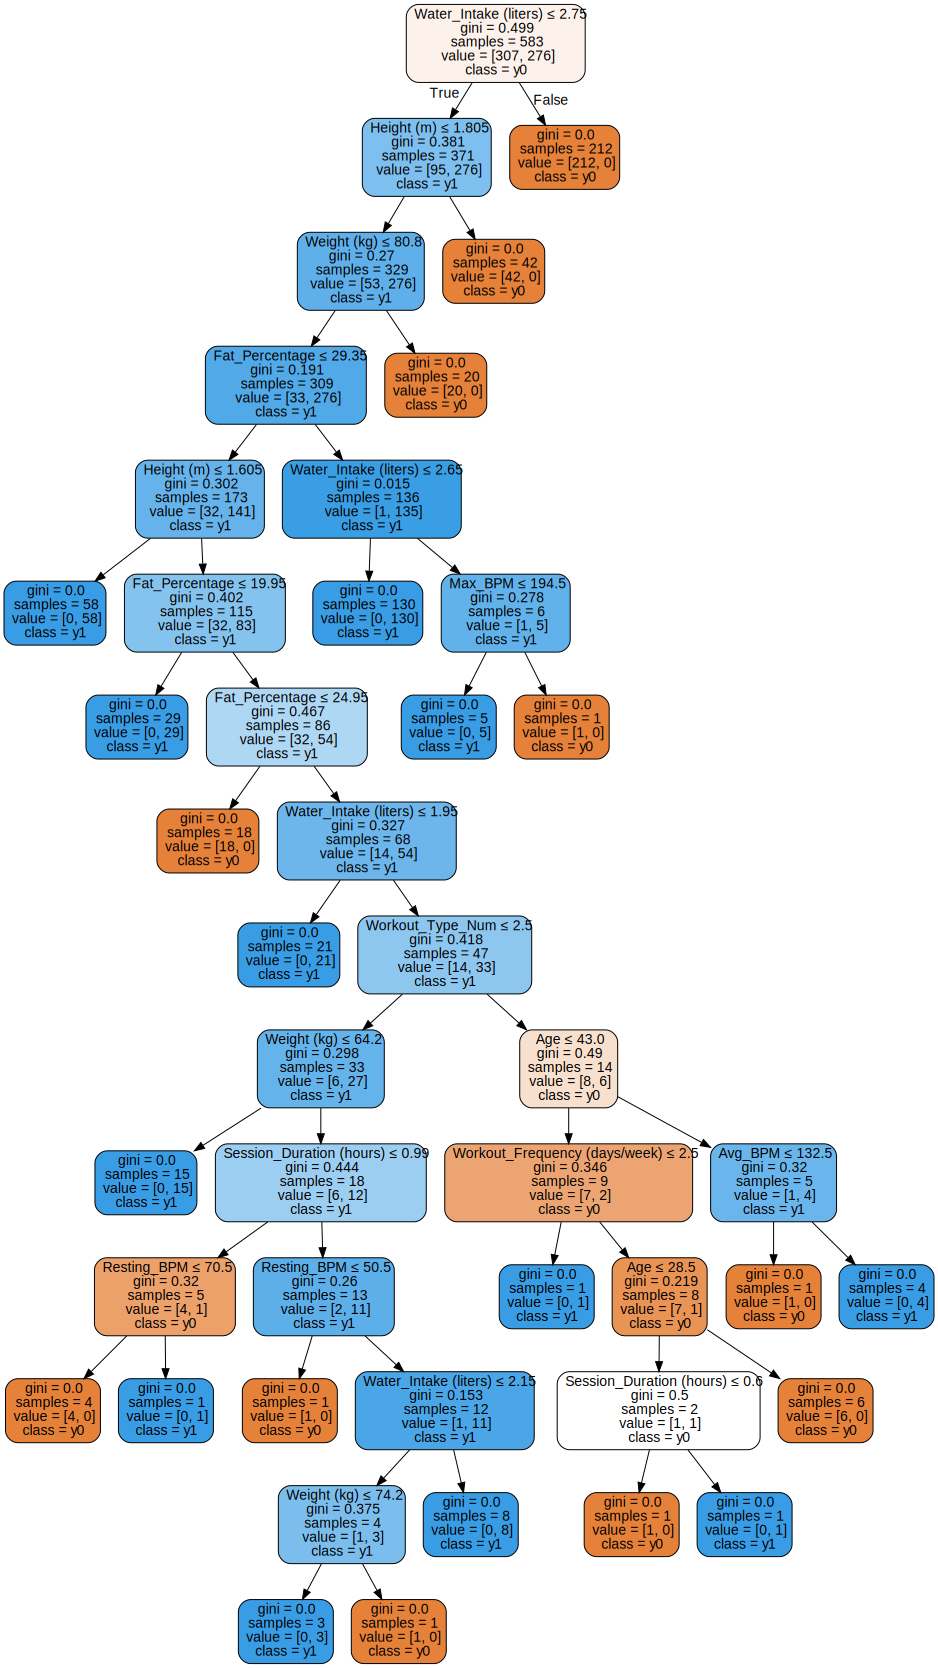

Модель дерева решений с объемом тестовой выборки: 0.100 и критерием разбиения: gini
Глубина дерева: 15
Количество листьев: 28



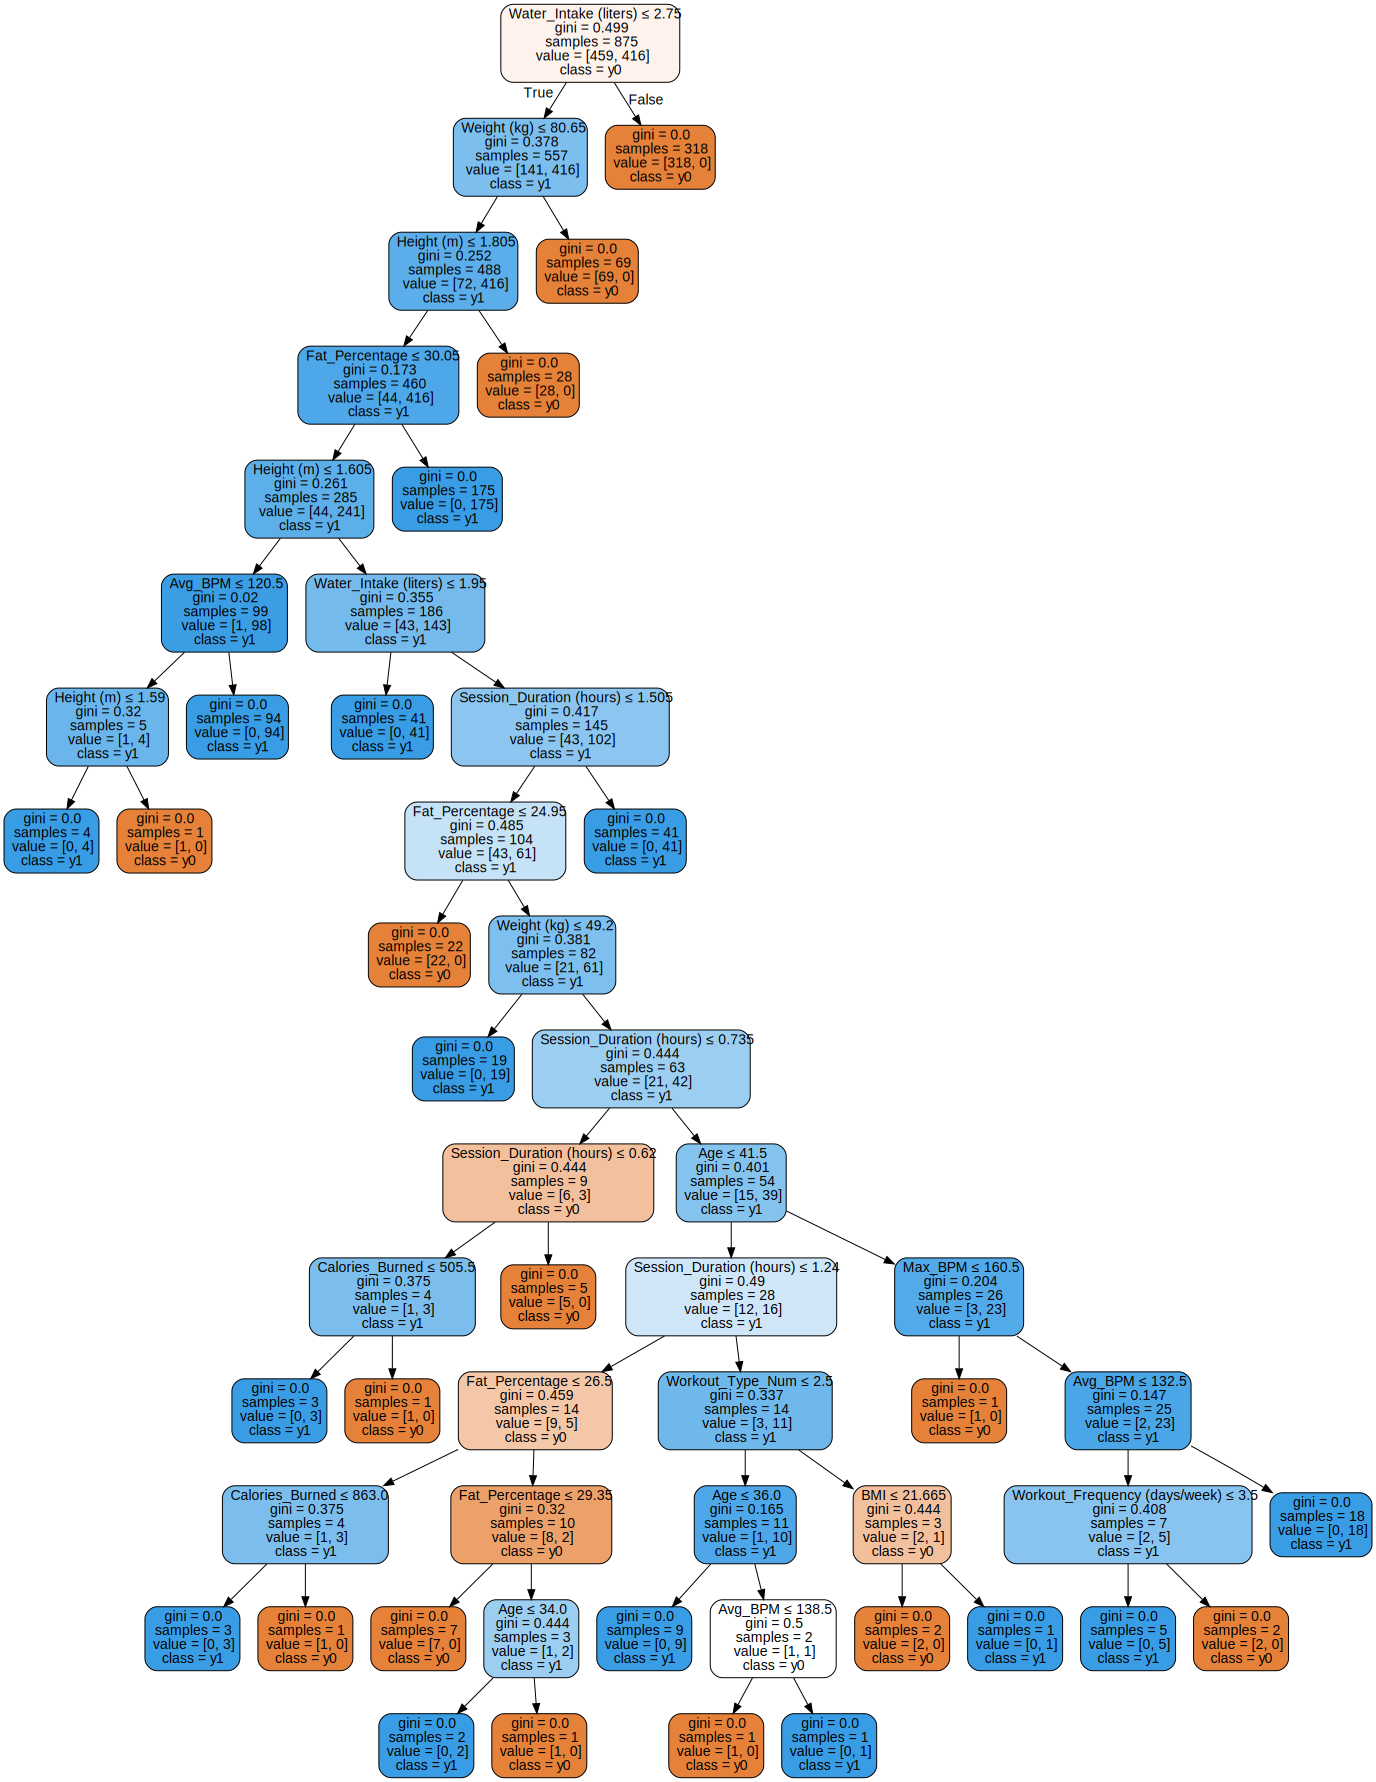

Модель дерева решений с объемом тестовой выборки: 0.400 и критерием разбиения: entropy
Глубина дерева: 17
Количество листьев: 19



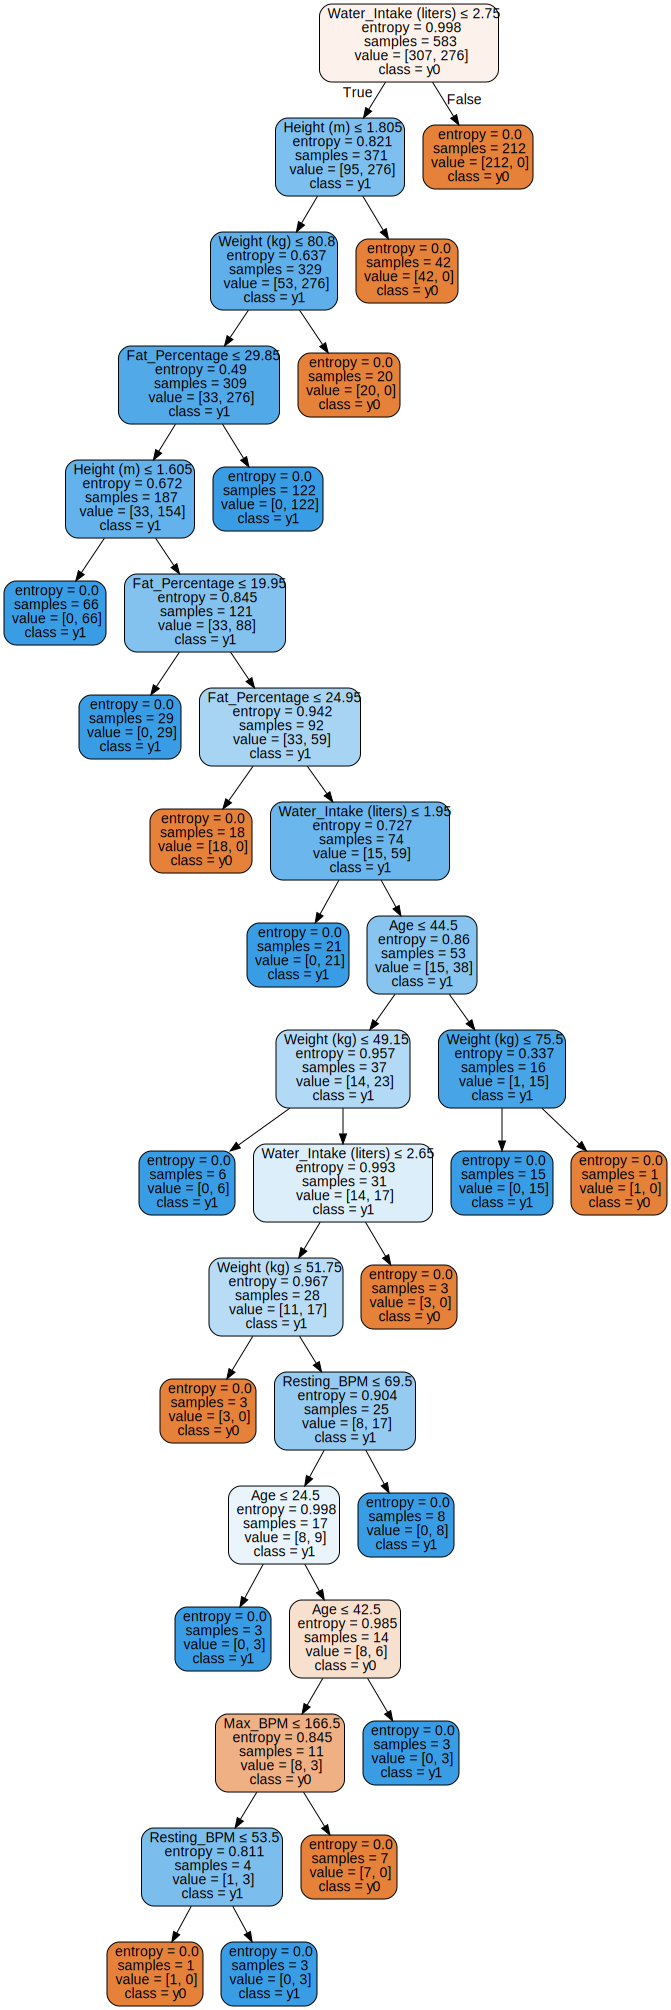

Модель дерева решений с объемом тестовой выборки: 0.100 и критерием разбиения: entropy
Глубина дерева: 16
Количество листьев: 22



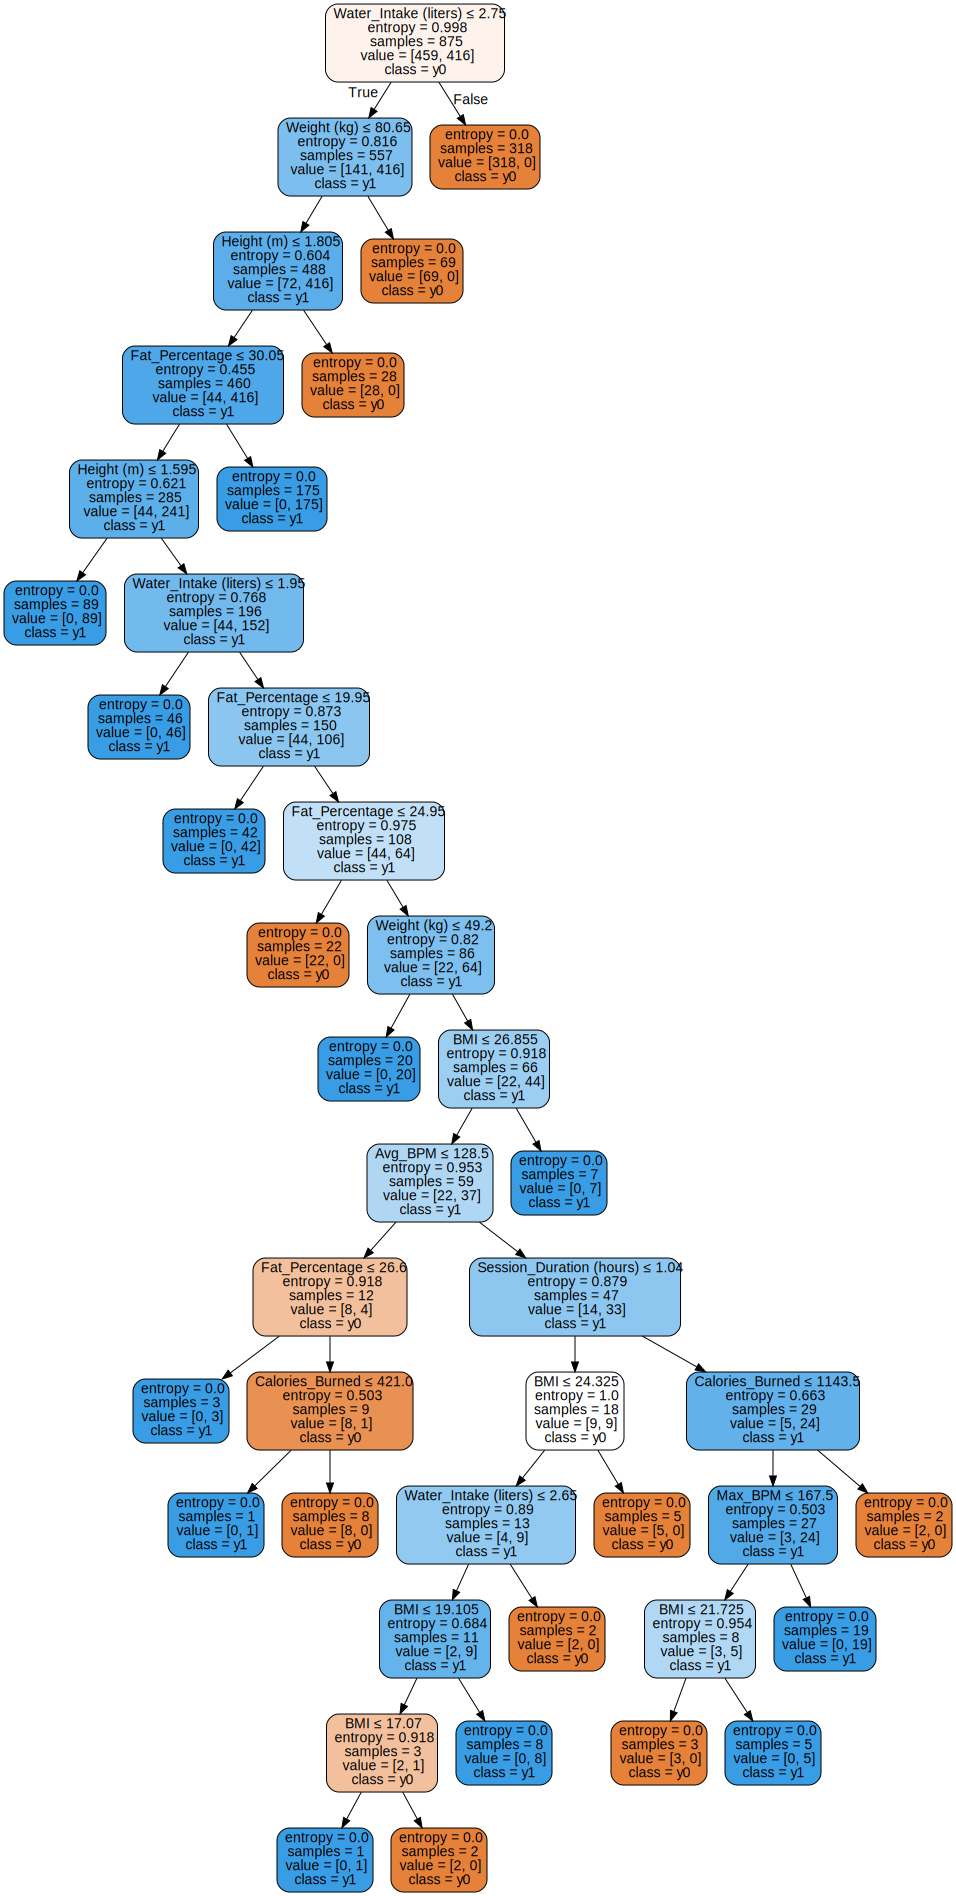

   Test_Size Criterion  Accuracy  Precision    Recall  F1-Score  Depth  Leaves
0        0.4      gini  0.956410   0.961749  0.946237  0.953930     14      23
1        0.1      gini  0.959184   0.977273  0.934783  0.955556     15      28
2        0.4   entropy  0.961538   0.962162  0.956989  0.959569     17      19
3        0.1   entropy  0.989796   1.000000  0.978261  0.989011     16      22


In [21]:
criterions = ['gini', 'entropy']
selected_test_sizes = [0.4, 0.1]

# Классификации и оценка метрик для выбранных выборок и критерия разбиения
for criterion in criterions:
    for test_size in selected_test_sizes:
        model, accuracy, precision, recall, f1, depth, leaves = classify_and_evaluate_decision_tree(X, y, test_size, criterion)
        results_decision_tree['Test_Size'].append(test_size)
        results_decision_tree['Criterion'].append(criterion)
        results_decision_tree['Accuracy'].append(accuracy)
        results_decision_tree['Precision'].append(precision)
        results_decision_tree['Recall'].append(recall)
        results_decision_tree['F1-Score'].append(f1)
        results_decision_tree['Depth'].append(depth)
        results_decision_tree['Leaves'].append(leaves)
        
        # Визуализация дерева решений
        visualize_decision_tree(model, X.columns, f"Дерево решений (Test Size {test_size:.3f}, Criterion {criterion})")

# Преобразование результатов в DataFrame
results_decision_tree_df = pd.DataFrame(results_decision_tree)
print(results_decision_tree_df)

Классификация производится на двух критериях: `gini` и`entropy`.
1. `gini`: измеряет чистоту узла, чем ниже значение, тем более однородные данные в узле. Показывает вероятность: случайно выбранный элемент классифицирован неверно, если метка была определена случайно по распределению меток в узле.
2. `entropy`: измеряет степень неопределенности. Чем ниже энтропия, тем данные более однородны. Оценивает предсказуемость данных.

1. Деление дерева прекращается, когда частота узла становится раавной 0 (все образцы относятся к одному классу).
2. Дерево достигло максимальной установленной глубин. По умолчанию, DecisionTreeClassifier из библиотеки scikit-learn строит дерево решений до тех пор, пока все листья не будут чистыми или каждый лист не будет содержать менее 2 образцов.
3. Количество образцов в узле меньше заданного порога.
4. Прекратилось увеличение улучшения качества классификации.

In [22]:
# хранение результатов
results_decision_tree = {
    'Test_Size': [],
    'Criterion': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Depth': [],
    'Leaves': []
}
criterions = ['gini', 'entropy']
test_sizes = np.arange(0.4, 0.1, -0.05).tolist()

In [23]:
# Классификации и оценка метрик для выбранных выборок и критерия разбиения
for criterion in criterions:
    for test_size in test_sizes:
        model, accuracy, precision, recall, f1, depth, leaves = classify_and_evaluate_decision_tree(X, y, test_size, criterion)
        results_decision_tree['Test_Size'].append(test_size)
        results_decision_tree['Criterion'].append(criterion)
        results_decision_tree['Accuracy'].append(accuracy)
        results_decision_tree['Precision'].append(precision)
        results_decision_tree['Recall'].append(recall)
        results_decision_tree['F1-Score'].append(f1)
        results_decision_tree['Depth'].append(depth)
        results_decision_tree['Leaves'].append(leaves)

Модель дерева решений с объемом тестовой выборки: 0.400 и критерием разбиения: gini
Глубина дерева: 14
Количество листьев: 23

Модель дерева решений с объемом тестовой выборки: 0.350 и критерием разбиения: gini
Глубина дерева: 14
Количество листьев: 23

Модель дерева решений с объемом тестовой выборки: 0.300 и критерием разбиения: gini
Глубина дерева: 15
Количество листьев: 24

Модель дерева решений с объемом тестовой выборки: 0.250 и критерием разбиения: gini
Глубина дерева: 15
Количество листьев: 23

Модель дерева решений с объемом тестовой выборки: 0.200 и критерием разбиения: gini
Глубина дерева: 15
Количество листьев: 23

Модель дерева решений с объемом тестовой выборки: 0.150 и критерием разбиения: gini
Глубина дерева: 14
Количество листьев: 22

Модель дерева решений с объемом тестовой выборки: 0.100 и критерием разбиения: gini
Глубина дерева: 15
Количество листьев: 28

Модель дерева решений с объемом тестовой выборки: 0.400 и критерием разбиения: entropy
Глубина дерева: 17
Колич

In [24]:
results_decision_tree_df = pd.DataFrame(results_decision_tree)
results_decision_tree_df

,Test_Size,Criterion,Accuracy,Precision,Recall,F1-Score,Depth,Leaves
0,0.40,gini,0.956410,0.961749,0.946237,0.953930,14,23
1,0.35,gini,0.961877,0.964286,0.958580,0.961424,14,23
2,0.30,gini,0.945205,0.965035,0.926174,0.945205,15,24
3,0.25,gini,0.967213,0.983471,0.952000,0.967480,15,23
4,0.20,gini,0.958974,0.978723,0.938776,0.958333,15,23
5,0.15,gini,0.958904,0.970588,0.942857,0.956522,14,22
6,0.10,gini,0.959184,0.977273,0.934783,0.955556,15,28
7,0.40,entropy,0.961538,0.962162,0.956989,0.959569,17,19
8,0.35,entropy,0.973607,0.970588,0.976331,0.973451,14,21
9,0.30,entropy,0.969178,0.972973,0.966443,0.969697,14,21


###  Визуализация полученных результатов

In [25]:
# Функция для построения столбчатой диаграммы
def plot_tree_comparison(results_df):
    results_df['Test_Size'] = results_df['Test_Size'].round(3).astype(str)
    fig, ax = plt.subplots(2, 1, figsize=(5, 6))
    
    # Диаграмма для глубины дерева
    sns.barplot(x='Test_Size', y='Depth', hue='Criterion', data=results_df, ax=ax[0])
    ax[0].set_title('Глубина дерева решений в зависимости от критерия разбиения и размера тестовой выборки')
    ax[0].set_xlabel('Размер тестовой выборки')
    ax[0].set_ylabel('Глубина дерева')
    ax[0].invert_xaxis()
    
    # Диаграмма для количества листьев
    sns.barplot(x='Test_Size', y='Leaves', hue='Criterion', data=results_df, ax=ax[1])
    ax[1].set_title('Количество листьев в зависимости от критерия разбиения и размера тестовой выборки')
    ax[1].set_xlabel('Размер тестовой выборки')
    ax[1].set_ylabel('Количество листьев')
    ax[1].invert_xaxis()

    plt.tight_layout()
    plt.show()

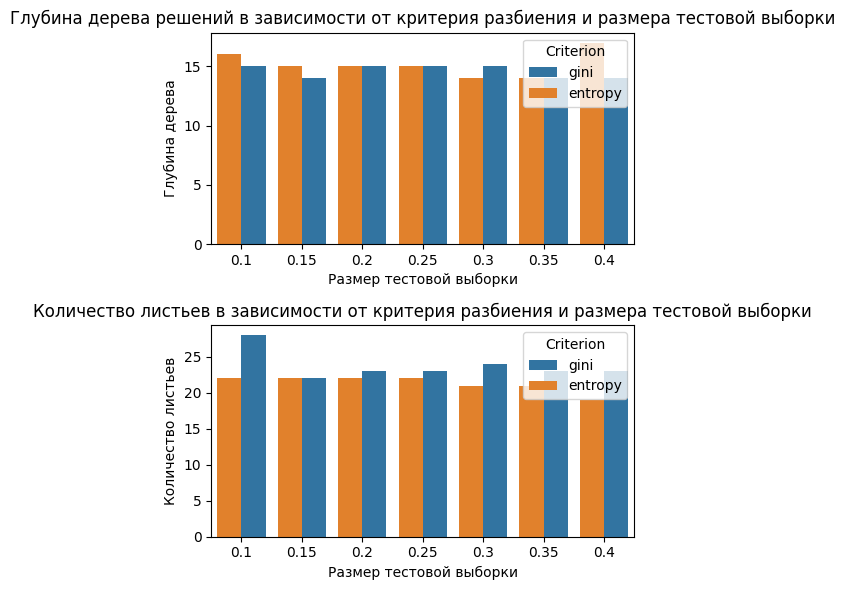

In [26]:
plot_tree_comparison(results_decision_tree_df)

Наблюдения.
1. Глубина дерева решений по критерию `entropy` выше в сравнении с `gini`. С увеличением размера тестовой выборки различия в глубине дерева между двумя критериями уменьшаются.
2. Количество листьев по критерию `entropy` ниже в сравнении с `gini`. С увеличением размера тестовой выборки различия в количестве листьев между двумя критериями уменьшаются.

In [27]:
def metric_visualiz_all(results, metrics):
    warnings.filterwarnings("ignore")
    
    results['Test_Size'] = results['Test_Size'].round(3)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='Criterion', data=results, marker='o', ax=ax)
        ax.set_title(f'{metric} в зависимости от критерия разбиения и размера тестовой выборки')
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)
        ax.invert_xaxis()
        ax.legend(title='Criterion')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

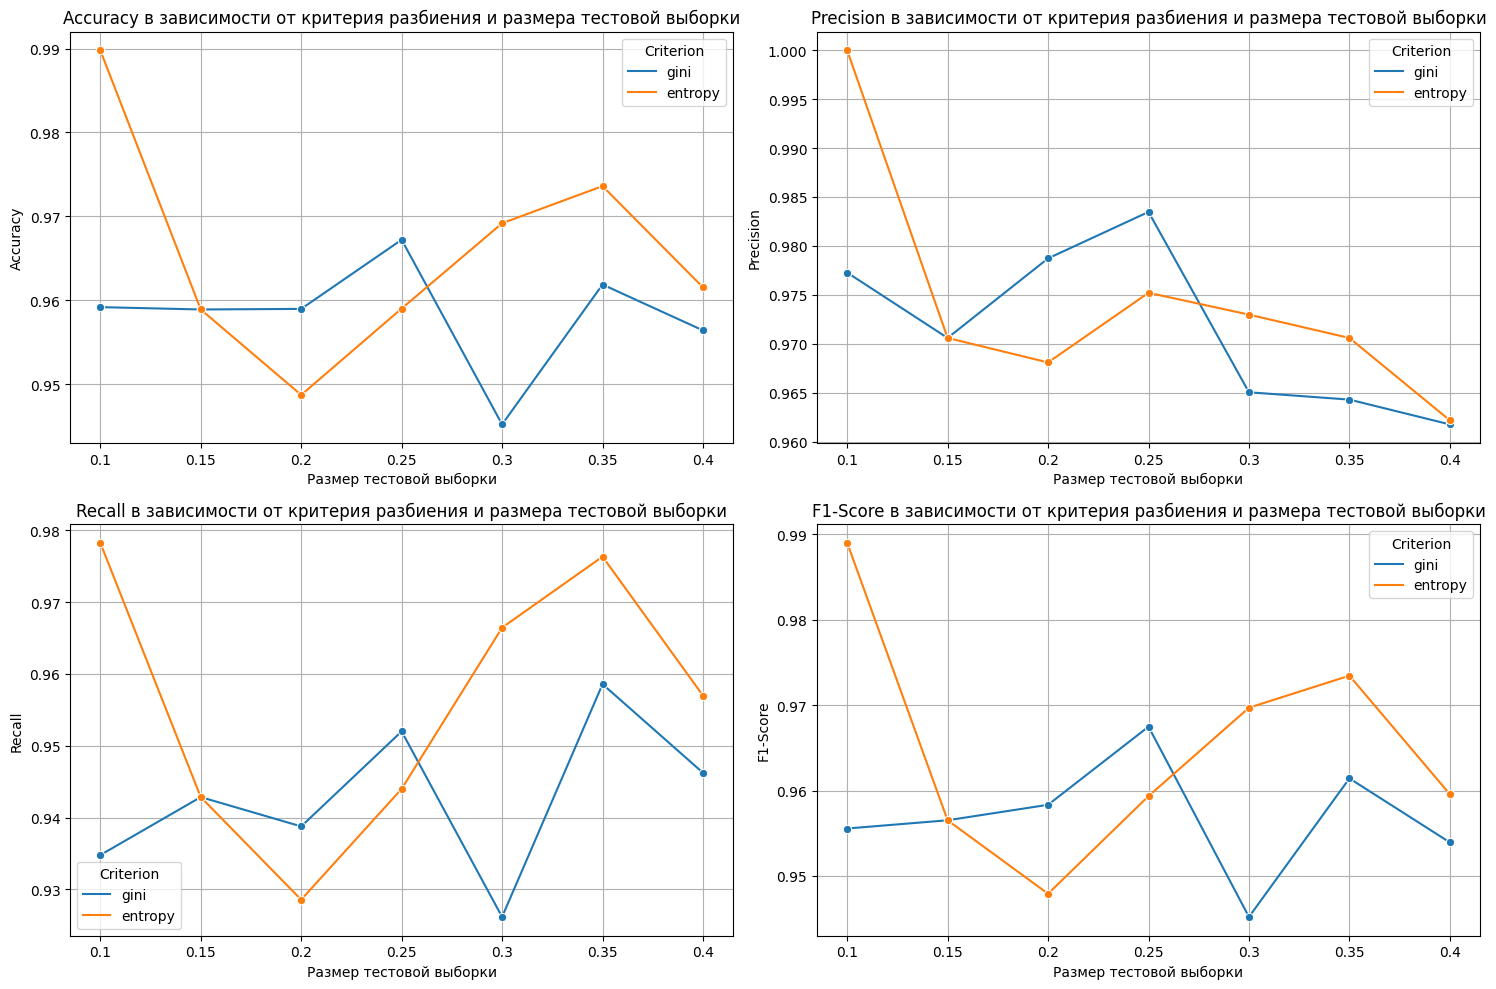

In [28]:
# Визуализация всех метрик
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualiz_all(results_decision_tree_df, metrics)

In [29]:
def metric_visualiz_all(results):
    warnings.filterwarnings("ignore")

    results['Test_Size'] = results['Test_Size'].round(3)
    
    # Создание фигуры и подграфиков
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle('Метрики')

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    criterions = ['gini', 'entropy']
    
    for i, criterion in enumerate(criterions):
        data_subset = results[results['Criterion'] == criterion]
        for metric in metrics:
            sns.lineplot(x='Test_Size', y=metric, data=data_subset, ax=axs[i], marker='o', label=metric)
        axs[i].set_title(f'Метрики ({criterion.capitalize()})')
        axs[i].set_xlabel('Размер тестовой выборки')
        axs[i].set_ylabel('Значение метрики')
        axs[i].invert_xaxis()
        axs[i].grid(True)
        axs[i].legend(title='Метрика')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

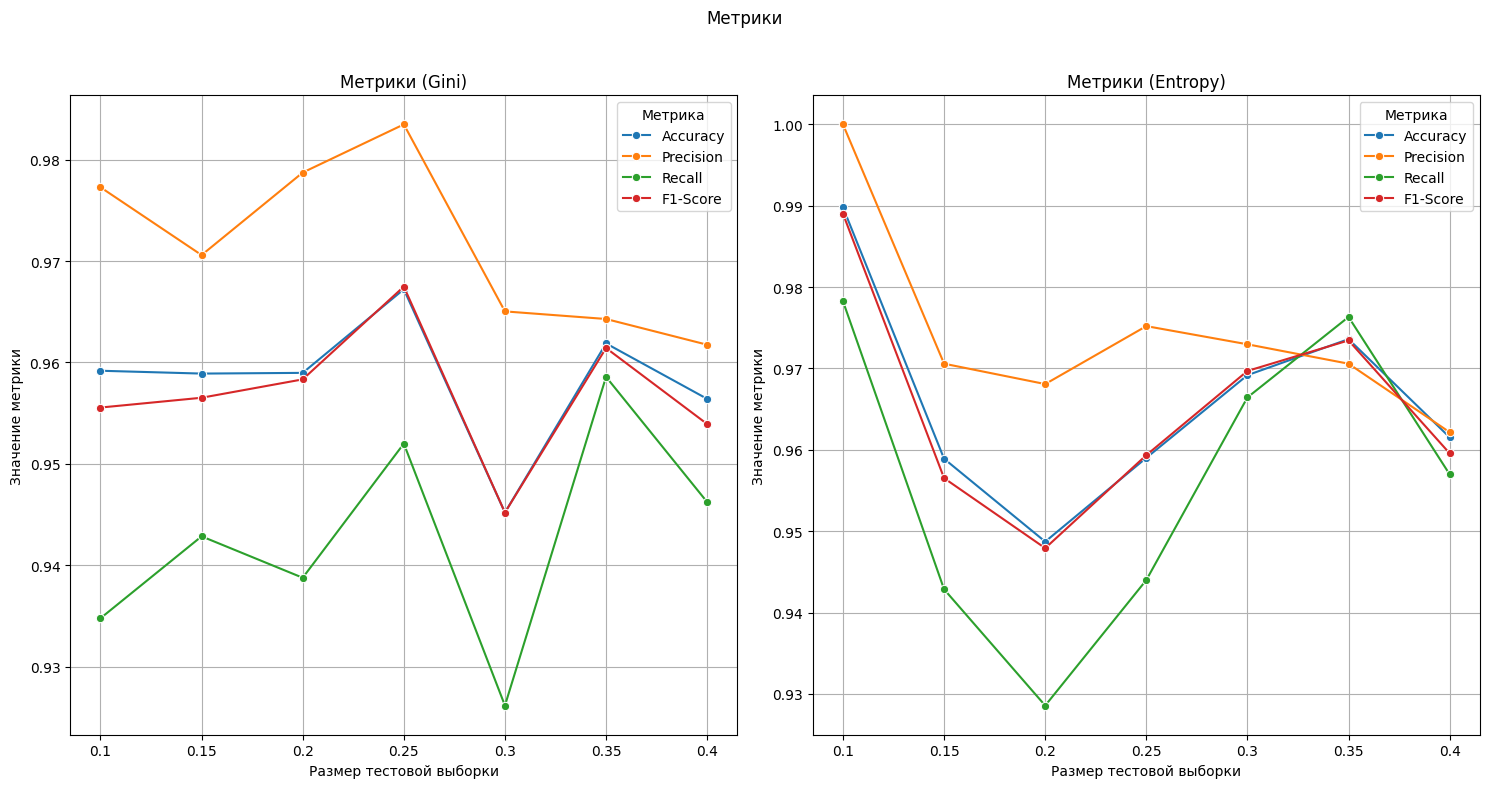

In [30]:
metric_visualiz_all(results_decision_tree_df)

###  Выводы по деревьям решений

График метрик `gini` в зависимости от размера тестовой выборки:
- точность варьируется от 0.965 до 0.945

График метрик`entropy`в зависимости от размера тестовой выборки:
- точность варьируется от 0.99 до 0.95.

Метод `Gini` обеспечивает большую стабильность в метриках Accuracy и Precision на разных размерах тестовой выборки. Метод `Entropy` демонстрирует большую изменчивость, особенно в метрике Recall.

Деревья по методу `Gini` имеют меньшую глубину и большее количество узлов, что делает их более устойчивыми к переобучению. Деревья по методу `Entropy` могут быть переобучены за счет большей глубины и сложности построения модели.

##  Бэггинг

1. Выполните классификацию набора данных из задания о Байесовской классификации с помощью бэггинга, варьируя количество участников ансамбля (от 50 до 100 с шагом 10).
2. Вычислите показатели качества классификации: аккуратность (accuracy), точность (precision), полнота (recall), F-мера. Выполните визуализацию полученных результатов в виде диаграмм. Нанесите на диаграммы соответствующие значения, полученные в заданиях о Байесовской классификации и деревьях решений.
3. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему.  

Классификация с помощью [бэггинга](https://scikit-learn.ru/stable/modules/ensemble.html#bagging-meta-estimator) в scikit-learn реализована по принципу ансамблевого метода: добиться улучшения производительности базовых моделей за счет объединения их результатов. В данном случае Базовой моделью выбран GaussianNB().
1. Производится многократный выбор подвыборки обучающего набора. Подвыборки используются в обучении моделей ансамбля.
2. Обучается отдельная базовая модель на каждой подвыборке.
3. Итоговый результат выбирается в виде мажоритарного голосования (выбор наиболее частого).

In [31]:
# Функция для выполнения классификации и вычисления метрик с помощью бэггинга
def classify_and_evaluate_bagging(X, y, test_size, n_estimators):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # обучение ансамбля моделей через GaussianNB() 
    model = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # модель
    print(f"Модель с объемом тестовой выборки: {test_size:.3f}, количество участников ансамбля: {n_estimators}")

    # предсказание
    y_pred = model.predict(X_test)
    
    # метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # тепловая карта для анализа результатов
    # plot_confusion_matrix_heatmap(y_test, y_pred, test_size, n_estimators)
    
    return accuracy, precision, recall, f1

In [32]:
# результаты обучения набора классификаторов
results_bagging = {
    'Test_Size': [],
    'n_Estimators': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}
# в заданном диапазоне:
n_estimators_range = range(50, 101, 10)

In [33]:
# классификация и оценка метрик
for n_estimators in n_estimators_range:
    for test_size in test_sizes:
        accuracy, precision, recall, f1 = classify_and_evaluate_bagging(X, y, test_size, n_estimators)
        results_bagging['Test_Size'].append(test_size)
        results_bagging['n_Estimators'].append(n_estimators)
        results_bagging['Accuracy'].append(accuracy)
        results_bagging['Precision'].append(precision)
        results_bagging['Recall'].append(recall)
        results_bagging['F1-Score'].append(f1)

results_bagging_df = pd.DataFrame(results_bagging)

Модель с объемом тестовой выборки: 0.400, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.350, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.300, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.250, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.200, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.150, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.100, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.400, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.350, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.300, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.250, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.200, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.150, количество участников ансамбля: 60

In [34]:
results_bagging_df.head() 

,Test_Size,n_Estimators,Accuracy,Precision,Recall,F1-Score
0,0.40,50,0.912821,0.883838,0.940860,0.911458
1,0.35,50,0.912023,0.883978,0.946746,0.914286
2,0.30,50,0.910959,0.886792,0.946309,0.915584
3,0.25,50,0.909836,0.887218,0.944000,0.914729
4,0.20,50,0.902564,0.869159,0.948980,0.907317


###  Визуализация метрик бэггинга

In [35]:
# визуализация метрик бэггинга в сетке 2x2
def metric_visualiz_bagging(results, metrics):
    warnings.filterwarnings("ignore")
    results['Test_Size'] = results['Test_Size'].round(3)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='n_Estimators', data=results, marker='o', ax=ax)
        ax.set_title(metric)
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)
        ax.legend(title='n_Estimators', loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    plt.tight_layout()
    plt.show()

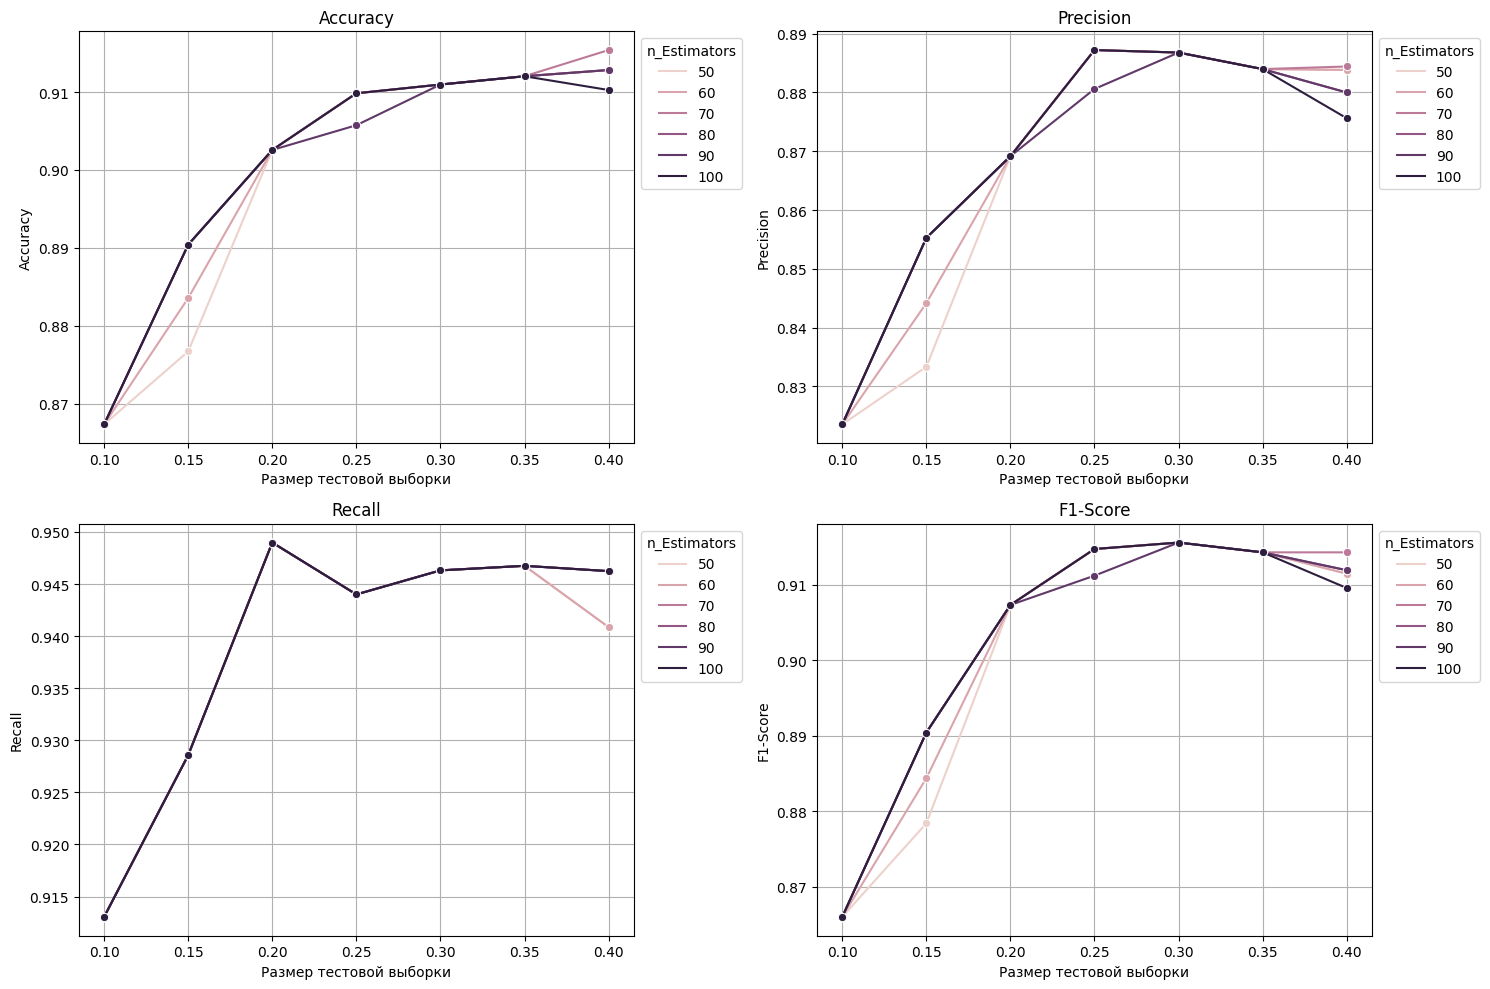

In [36]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualiz_bagging(results_bagging_df, metrics)

In [37]:
def metric_visualiz_all_methods(results_bagging, results_bayes, results_decision_tree, metrics):
    warnings.filterwarnings("ignore")
    
    # Округление значений Test_Size
    results_bagging['Test_Size'] = results_bagging['Test_Size'].round(3)
    results_bayes['Test_Size'] = results_bayes['Test_Size'].round(3)
    results_decision_tree['Test_Size'] = results_decision_tree['Test_Size'].round(3)

    # Общий DataFrame для всех методов
    results_bagging['Method'] = results_bagging['n_Estimators'].apply(lambda x: f'Bagging (n={x})')
    results_bayes['Method'] = 'Bayesian'
    results_decision_tree['Method'] = results_decision_tree['Criterion'].apply(lambda x: f'Decision Tree ({x.capitalize()})')

    combined_results = pd.concat([results_bagging, results_bayes, results_decision_tree], ignore_index=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Разбивка по цветам
    palette = {
        **{f'Bagging (n={x})': sns.color_palette("Blues")[i % 6] for i, x in enumerate(results_bagging['n_Estimators'].unique())},
        'Bayesian': 'orange',
        'Decision Tree (Gini)': 'limegreen',
        'Decision Tree (Entropy)': 'darkgreen'
    }

    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='Method', data=combined_results, marker='o', palette=palette, ax=ax)
        ax.set_title(f'{metric}')
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

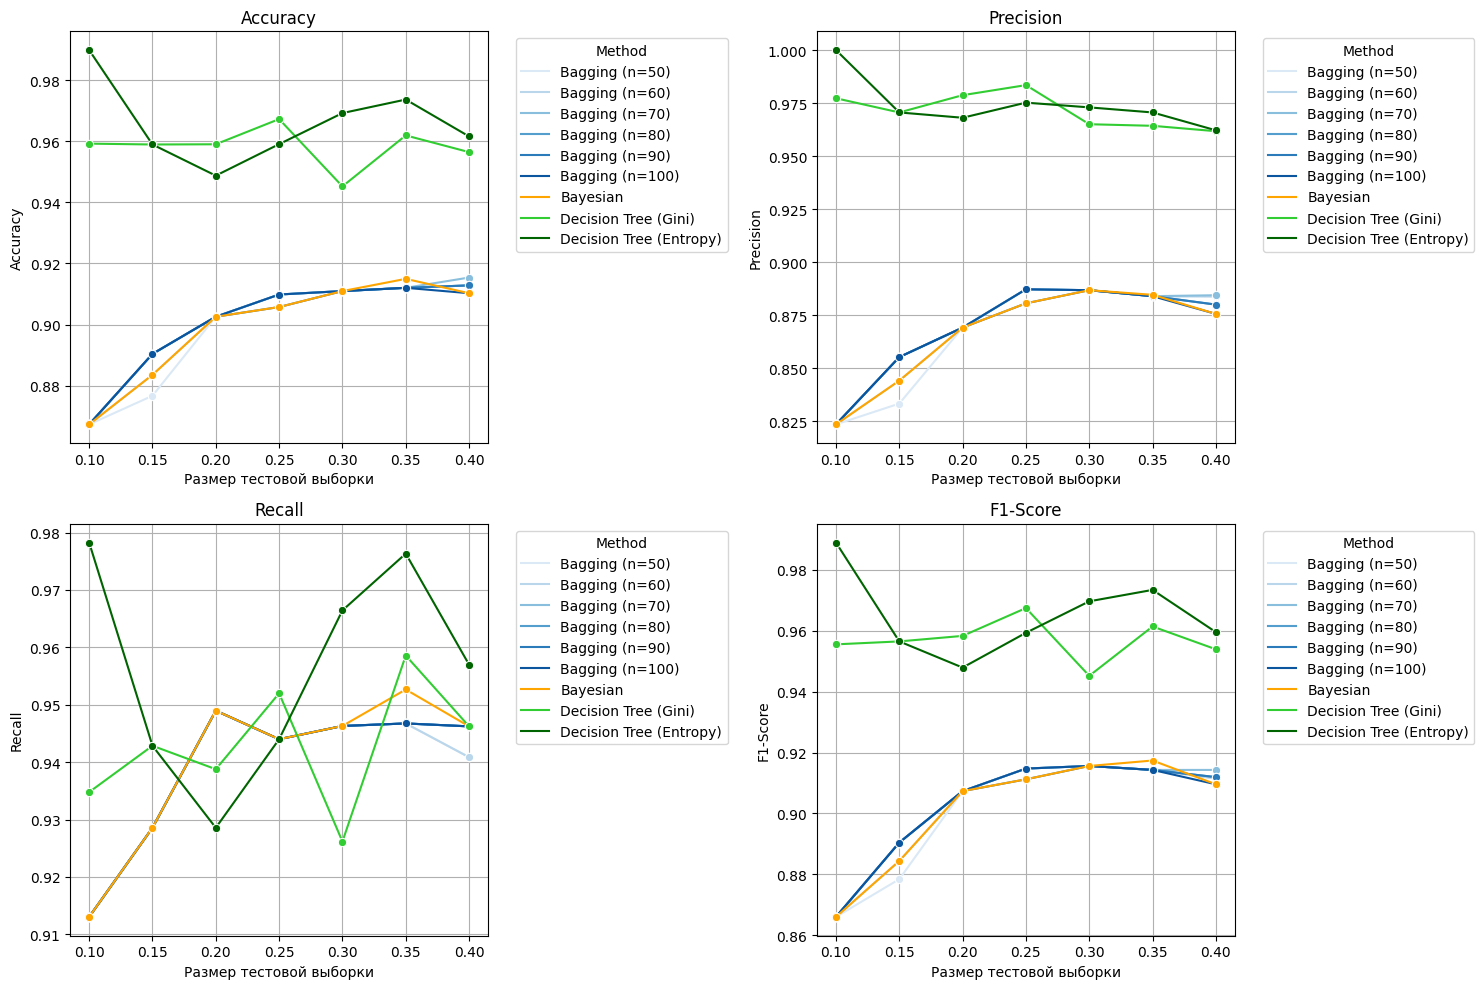

In [38]:
# Визуализация всех метрик по всем моделям
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualiz_all_methods(results_bagging_df, results_bayes_df, results_decision_tree_df, metrics)


###  Выводы по классификации методом бэггинга

Точность Баейсовской классификации сопоставима с деревьями решений. Возможна потеря точности в случае зависимых друг от друга атрибутов. Используется как теоретическое обоснование других классификаторов.

Недостатки использования деревьев: сложно найти лучшее дерево, возможно переобучение.

В бэггинге сложно интерпретировать результаты по сравнению с одним классификатором, поскольку значения для разного количества участников ансамбля отличаются. 

Сравнение моделей.
1. Точность: деревья решений показали наибольшую точность по сравнению с методом Баейсовской классификации и бэггинга (на них точность совпадает за счет применения одной и той же базовой модели Гаусса).
2. Точность предсказаний: деревья решений наиболее точные, при этом применение ансамблевого метода бэггинг точнее простой модели Баейсовской классификации.
3. Recall: дерево решений с энтропией показало лучшие результаты с уменьшением размера тестовой выборки. Производительность на бэггинге уменьшилась с уменьшением размера тестовой выборки.
4. F1-Score: деревья решений показали лучшие результаты, в т.ч. на малых размерах тестовой выборки. Бэггинг и баейсовская классификация совпали и привели к ухудшению результата на малой тестовой выборке.



##  Случайный лес

В библиотеке [RandomForestClassifier](https://scikit-learn.ru/stable/modules/ensemble.html#random-forest) является ансамблевым методом: используется множество деревьев для принятия решений. Метод основан на объединении слабых моделей (деревьев) в одну сильную модель. По умолчанию в методе используется критерий `gini` для разбиения узлов. Для каждого разбиения узла выбирается случайное подмножество признаков. В задаче классификации каждое дерево голосует за класс, и итоговый класс определяется большинством голосов.

In [39]:
# Функция для выполнения классификации и вычисления метрик с помощью случайного леса
def classify_and_evaluate_random_forest(X, y, test_size, n_estimators):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Обучение случайного леса
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание
    y_pred = model.predict(X_test)

    # модель
    print(f"Модель с объемом тестовой выборки: {test_size:.3f}, количество участников ансамбля: {n_estimators}")
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1

In [40]:
# хранимые езультаты обучения набора классификаторов
results_random_forest = {
    'Test_Size': [],
    'n_Estimators': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# в заданном диапазоне
n_estimators_range = range(50, 101, 10)

# соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 5%
test_sizes = np.arange(0.4, 0.1, -0.05).tolist()

In [41]:
# Классификация и оценка метрик
for n_estimators in n_estimators_range:
    for test_size in test_sizes:
        accuracy, precision, recall, f1 = classify_and_evaluate_random_forest(X, y, test_size, n_estimators)
        results_random_forest['Test_Size'].append(test_size)
        results_random_forest['n_Estimators'].append(n_estimators)
        results_random_forest['Accuracy'].append(accuracy)
        results_random_forest['Precision'].append(precision)
        results_random_forest['Recall'].append(recall)
        results_random_forest['F1-Score'].append(f1)

results_random_forest_df = pd.DataFrame(results_random_forest)

Модель с объемом тестовой выборки: 0.400, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.350, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.300, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.250, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.200, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.150, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.100, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.400, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.350, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.300, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.250, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.200, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.150, количество участников ансамбля: 60

In [42]:
results_random_forest_df.head() 

,Test_Size,n_Estimators,Accuracy,Precision,Recall,F1-Score
0,0.40,50,0.969231,0.948454,0.989247,0.968421
1,0.35,50,0.979472,0.960227,1.000000,0.979710
2,0.30,50,0.982877,0.973684,0.993289,0.983389
3,0.25,50,0.991803,0.984252,1.000000,0.992063
4,0.20,50,0.984615,0.970297,1.000000,0.984925


### Визуализация полученных результатов 

In [43]:
def metric_visualiz_random_forest(results, metrics):
    warnings.filterwarnings("ignore")
    results['Test_Size'] = results['Test_Size'].round(3)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='n_Estimators', data=results, marker='o', ax=ax)
        ax.set_title(metric)
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)
        ax.legend(title='n_Estimators', loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    plt.tight_layout()
    plt.show()

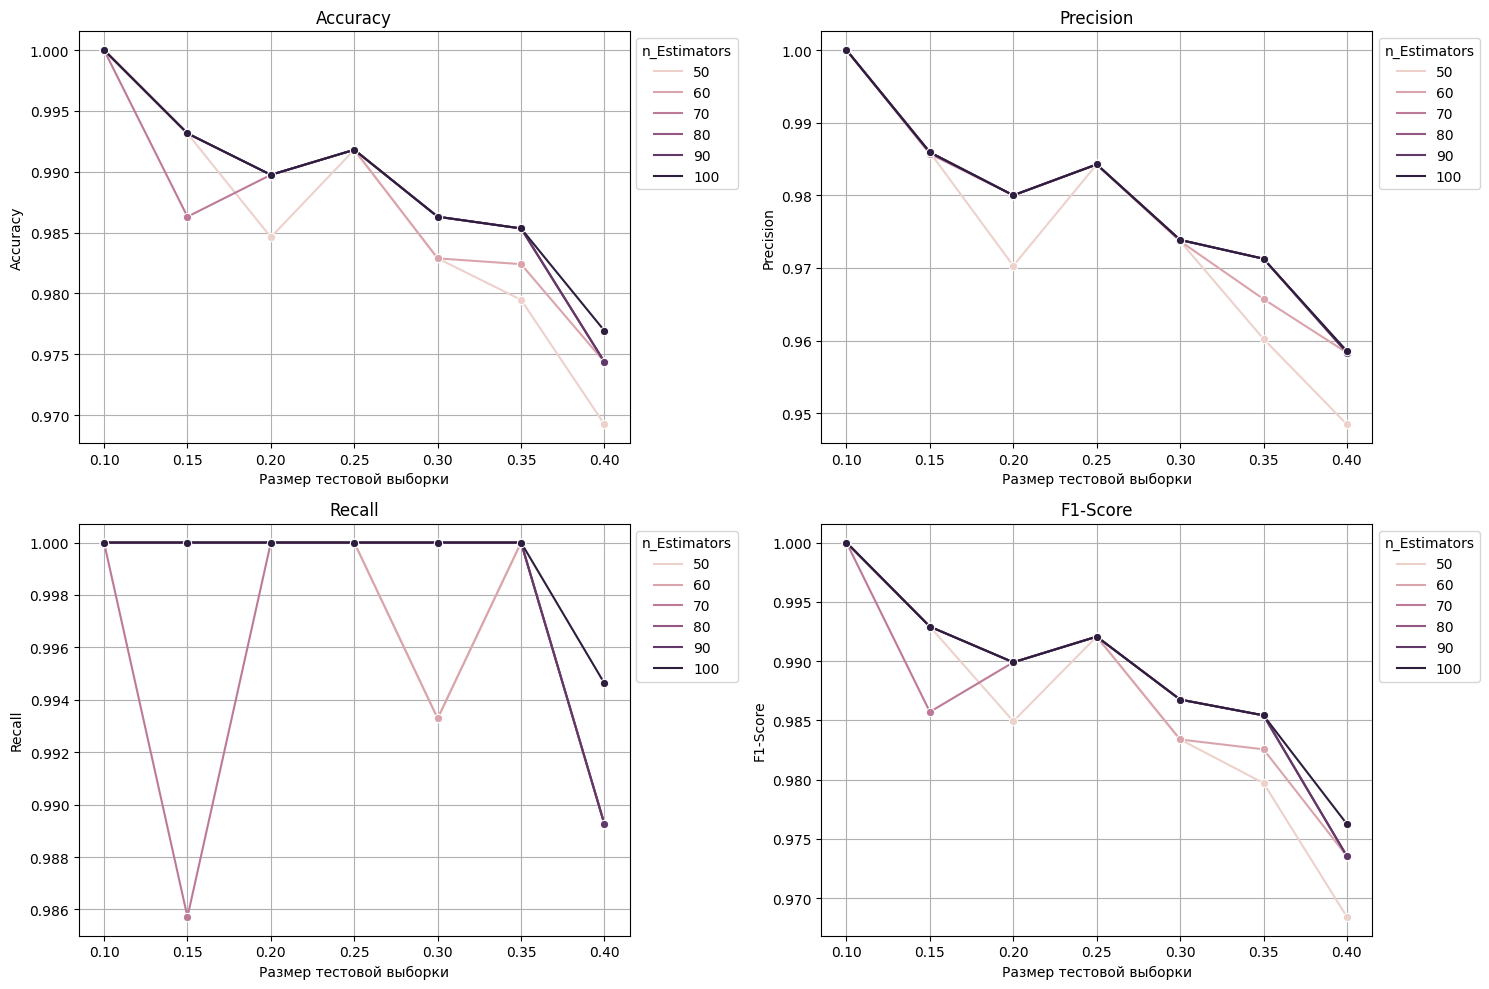

In [44]:
# Визуализация всех метрик
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualiz_random_forest(results_random_forest_df, metrics)

In [45]:
# Функция для визуализации всех методов
def metric_visualiz_all_methods(results_bagging, results_random_forest, results_bayes, results_decision_tree, metrics):
    warnings.filterwarnings("ignore")
    
    # Округление значений Test_Size
    results_bagging['Test_Size'] = results_bagging['Test_Size'].round(3)
    results_random_forest['Test_Size'] = results_random_forest['Test_Size'].round(3)
    results_bayes['Test_Size'] = results_bayes['Test_Size'].round(3)
    results_decision_tree['Test_Size'] = results_decision_tree['Test_Size'].round(3)

    # Общий DataFrame для всех методов
    results_bagging['Method'] = results_bagging['n_Estimators'].apply(lambda x: f'Bagging (n={x})')
    results_random_forest['Method'] = results_random_forest['n_Estimators'].apply(lambda x: f'Random Forest (n={x})')
    results_bayes['Method'] = 'Bayesian'
    results_decision_tree['Method'] = results_decision_tree['Criterion'].apply(lambda x: f'Decision Tree ({x.capitalize()})')

    combined_results = pd.concat([results_bagging, results_random_forest, results_bayes, results_decision_tree], ignore_index=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Разбивка по цветам
    palette = {
        **{f'Bagging (n={x})': sns.color_palette("Blues")[i % 6] for i, x in enumerate(results_bagging['n_Estimators'].unique())},
        **{f'Random Forest (n={x})': sns.color_palette("Reds")[i % 6] for i, x in enumerate(results_random_forest['n_Estimators'].unique())},
        'Bayesian': 'orange',
        'Decision Tree (Gini)': 'limegreen',
        'Decision Tree (Entropy)': 'darkgreen'
    }

    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='Method', data=combined_results, marker='o', palette=palette, ax=ax)
        ax.set_title(f'{metric}')
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)

        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

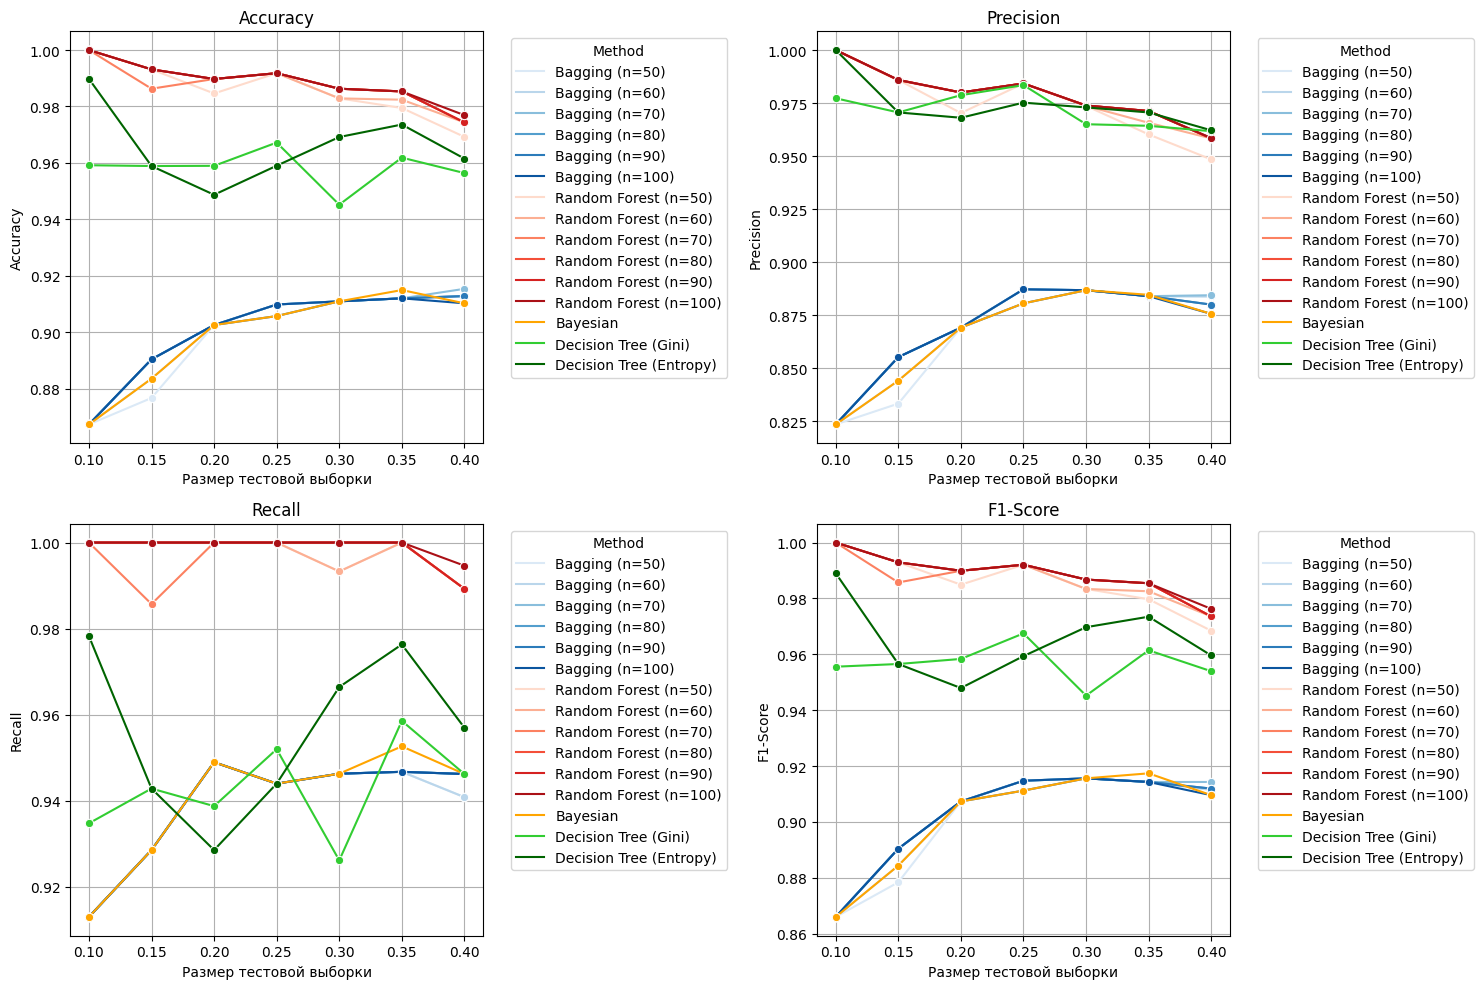

In [46]:
metric_visualiz_all_methods(results_bagging_df, results_random_forest_df, results_bayes_df, results_decision_tree_df, metrics)

###  Выводы по случайному лесу

Модель случайного леса показывает более высокую точность на всех графиках. С увеличением количества моделей в ансамбле точность увеличивается. Значительное увеличение количества моделей в ансамбле более 70 не приводит к явному улучшению производительности. Модель случайного леса хорошо подходит в условиях малой обучающей выборке на небольших наборах данных.

С уменьшением объема обучающей выборки лучше всего для данного набора использовать модель бэггинга. При этом значительное увеличение количества моделей в ансамбле не дает значительного прироста в точности.

## Бустинг

In [47]:
def classify_and_evaluate_boosting(X, y, test_size, n_estimators):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Обучение бустинга
    model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание
    y_pred = model.predict(X_test)

    # модель
    print(f"Модель с объемом тестовой выборки: {test_size:.3f}, количество участников ансамбля: {n_estimators}")
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1


In [48]:
results_boosting = {
    'Test_Size': [],
    'n_Estimators': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# в заданном диапазоне
n_estimators_range = range(50, 101, 10)

# соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 5%
test_sizes = np.arange(0.4, 0.1, -0.05).tolist()

# Классификация и оценка метрик
for n_estimators in n_estimators_range:
    for test_size in test_sizes:
        accuracy, precision, recall, f1 = classify_and_evaluate_boosting(X, y, test_size, n_estimators)
        results_boosting['Test_Size'].append(test_size)
        results_boosting['n_Estimators'].append(n_estimators)
        results_boosting['Accuracy'].append(accuracy)
        results_boosting['Precision'].append(precision)
        results_boosting['Recall'].append(recall)
        results_boosting['F1-Score'].append(f1)

results_boosting_df = pd.DataFrame(results_boosting)

Модель с объемом тестовой выборки: 0.400, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.350, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.300, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.250, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.200, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.150, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.100, количество участников ансамбля: 50
Модель с объемом тестовой выборки: 0.400, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.350, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.300, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.250, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.200, количество участников ансамбля: 60
Модель с объемом тестовой выборки: 0.150, количество участников ансамбля: 60

In [49]:
results_boosting_df.head() 

,Test_Size,n_Estimators,Accuracy,Precision,Recall,F1-Score
0,0.40,50,0.971795,0.972450,0.971795,0.971809
1,0.35,50,0.979472,0.979890,0.979472,0.979470
2,0.30,50,0.976027,0.976219,0.976027,0.976020
3,0.25,50,0.987705,0.987993,0.987705,0.987699
4,0.20,50,0.984615,0.985072,0.984615,0.984611


###  Визуализация полученных результатов

In [50]:
def metric_visualiz_boosting(results, metrics):
    warnings.filterwarnings("ignore")
    results['Test_Size'] = results['Test_Size'].round(3)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='n_Estimators', data=results, marker='o', ax=ax)
        ax.set_title(metric)
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)
        ax.legend(title='n_Estimators', loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    plt.tight_layout()
    plt.show()

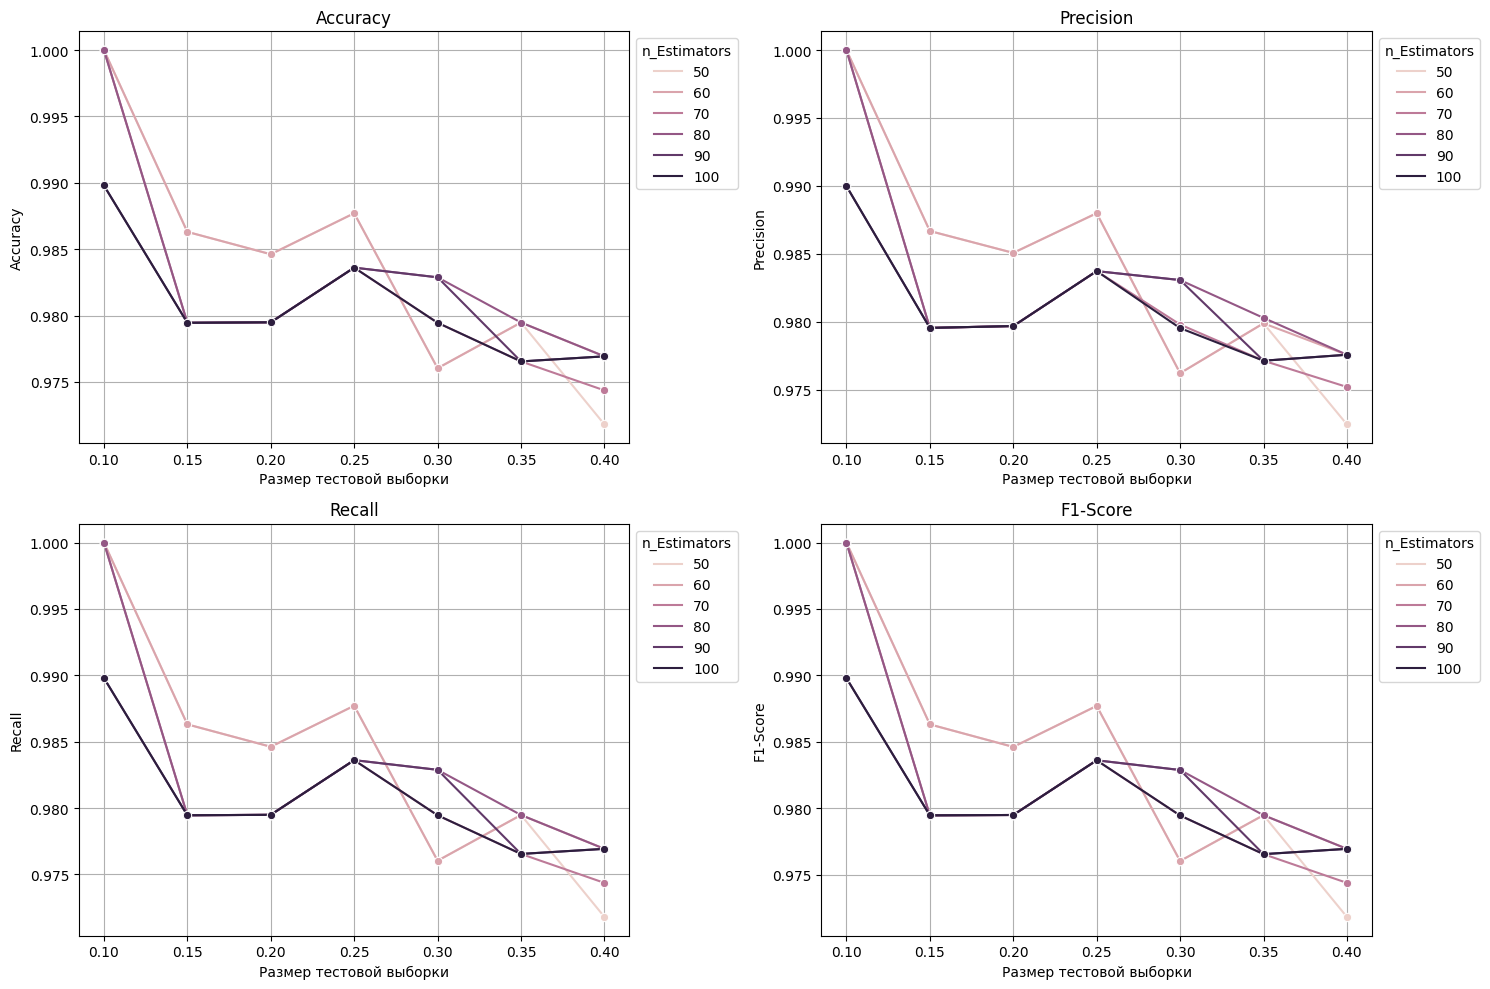

In [51]:
# Визуализация всех метрик
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualiz_boosting(results_boosting_df, metrics)

In [52]:
def metric_visualiz_all_methods(results_bagging, results_random_forest, results_bayes, results_decision_tree, results_boosting, metrics):
    warnings.filterwarnings("ignore")
    
    # Округление значений Test_Size
    results_bagging['Test_Size'] = results_bagging['Test_Size'].round(3)
    results_random_forest['Test_Size'] = results_random_forest['Test_Size'].round(3)
    results_bayes['Test_Size'] = results_bayes['Test_Size'].round(3)
    results_decision_tree['Test_Size'] = results_decision_tree['Test_Size'].round(3)
    results_boosting['Test_Size'] = results_boosting['Test_Size'].round(3)

    # Общий DataFrame для всех методов
    results_bagging['Method'] = results_bagging['n_Estimators'].apply(lambda x: f'Bagging (n={x})')
    results_random_forest['Method'] = results_random_forest['n_Estimators'].apply(lambda x: f'Random Forest (n={x})')
    results_boosting['Method'] = results_boosting['n_Estimators'].apply(lambda x: f'Boosting (n={x})')
    results_bayes['Method'] = 'Bayesian'
    results_decision_tree['Method'] = results_decision_tree['Criterion'].apply(lambda x: f'Decision Tree ({x.capitalize()})')

    combined_results = pd.concat([results_bagging, results_random_forest, results_boosting, results_bayes, results_decision_tree], ignore_index=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Разбивка по цветам
    palette = {
        **{f'Bagging (n={x})': sns.color_palette("Blues")[i % 6] for i, x in enumerate(results_bagging['n_Estimators'].unique())},
        **{f'Random Forest (n={x})': sns.color_palette("Reds")[i % 6] for i, x in enumerate(results_random_forest['n_Estimators'].unique())},
        **{f'Boosting (n={x})': sns.color_palette("Purples")[i % 6] for i, x in enumerate(results_boosting['n_Estimators'].unique())},
        'Bayesian': 'orange',
        'Decision Tree (Gini)': 'limegreen',
        'Decision Tree (Entropy)': 'darkgreen'
    }

    for ax, metric in zip(axes.flat, metrics):
        sns.lineplot(x='Test_Size', y=metric, hue='Method', data=combined_results, marker='o', palette=palette, ax=ax)
        ax.set_title(f'{metric}')
        ax.set_xlabel('Размер тестовой выборки')
        ax.set_ylabel(metric)
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

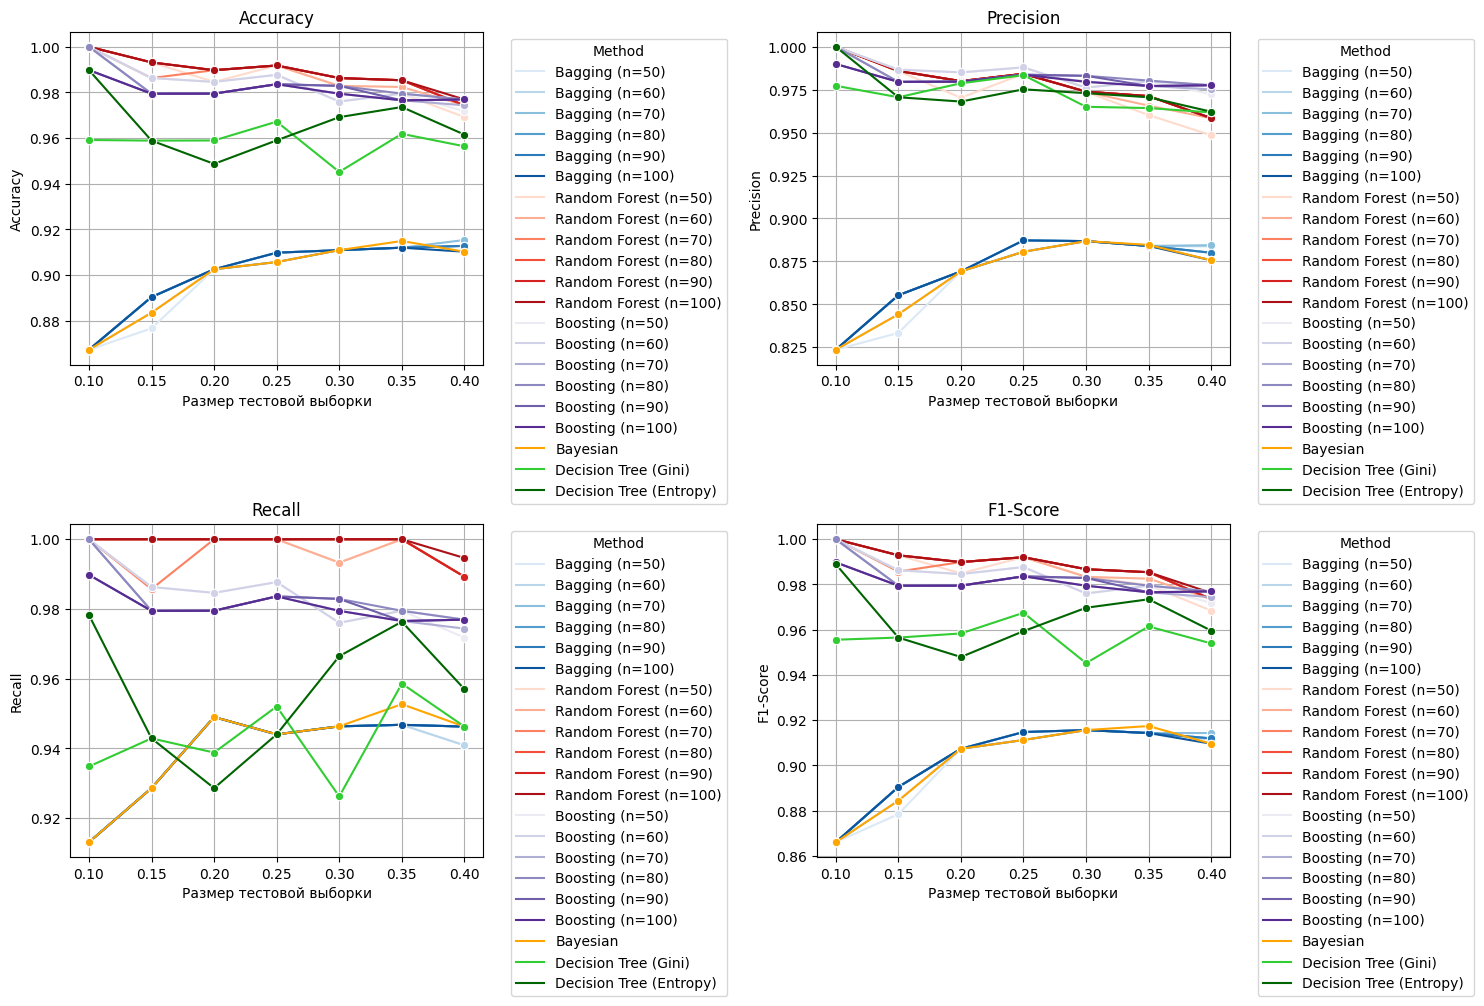

In [53]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_visualiz_all_methods(results_bagging_df, results_random_forest_df, results_bayes_df, results_decision_tree_df, results_boosting_df, metrics)

###  Выводы по бустингу
1. При малой тестовой выборке наблюдается высокая точность. Точность снижается с увеличением размера тестовой выборки.
2. Точность предсказаний: соизмерима с моделями деревьев решений и случайного леса.
3. Recall: высокое значение на малом значении участников ансамбля (противоположно модели случайного леса).
4. F1-Score: высокое значение на большом количестве участников ансамбля с увеличением размера тестовой выборки.

## Общие выводы по задаче классификации

1. Методы классификации Bagging, Random Forest, и Boosting показали высокие значения по всем метрикам. При малом наборе данных и высоком проценте тестовой выборке следует отдать предпочтение одному из этих методов.
2. Увеличение количества участников ансамблей не всегда приводит к увеличению точности модели на большой тестовой выборке. При увеличении количества деревьев было достигнуто незначительное увеличение значений метрик.
3. Random Forest менее устойчив к переобучению в сравнении с  Bagging.